# OASIS Combined Dataset Exploration (OASIS-1, 2, 3)

This notebook explores all three OASIS (Open Access Series of Imaging Studies) datasets for normative modeling of dementia.

**Datasets**:
- **OASIS-1**: Cross-sectional MRI (436 subjects)
- **OASIS-2**: Longitudinal MRI (150 subjects, multiple visits)
- **OASIS-3**: Longitudinal MRI/PET (1,378 subjects, multiple visits)

**Focus**: Healthy controls aged ≥50 years with T1-weighted MRI imaging  
**Criterion**: CDR (Clinical Dementia Rating) = 0 (normal cognition)  
**Visit Selection**: Baseline only (to maintain statistical independence)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Load and Prepare OASIS-1 (Cross-sectional)

In [2]:
# Load OASIS-1 clinical data
oasis1 = pd.read_excel('data/OASIS/OASIS1/oasis_cross-sectional_clinical_data.xlsx')

print("OASIS-1 (Cross-sectional MRI Data)")
print("=" * 60)
print(f"Total subjects: {len(oasis1):,}")
print(f"\nColumns: {list(oasis1.columns)}")

# Filter for healthy controls age >=50
oasis1_healthy = oasis1[(oasis1['CDR'] == 0) & (oasis1['Age'] >= 50)].copy()
oasis1_healthy['dataset'] = 'OASIS1'
oasis1_healthy['sex'] = oasis1_healthy['M/F']
oasis1_healthy['age'] = oasis1_healthy['Age']
oasis1_healthy['subject_id'] = oasis1_healthy['ID']

print(f"\nHealthy controls (CDR=0) age ≥50: {len(oasis1_healthy):,}")
print(f"Age range: {oasis1_healthy['age'].min():.0f}-{oasis1_healthy['age'].max():.0f}")
print(f"Sex distribution:\n{oasis1_healthy['sex'].value_counts()}")

OASIS-1 (Cross-sectional MRI Data)
Total subjects: 436

Columns: ['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay']

Healthy controls (CDR=0) age ≥50: 120
Age range: 50-94
Sex distribution:
sex
F    88
M    32
Name: count, dtype: int64


## 2. Load and Prepare OASIS-2 (Longitudinal)

In [3]:
# Load OASIS-2 longitudinal data
oasis2 = pd.read_excel('data/OASIS/OASIS2/oasis2_longitudinal_demographics-.xlsx')

print("OASIS-2 (Longitudinal MRI Data)")
print("=" * 60)
print(f"Total records (all visits): {len(oasis2):,}")
print(f"Unique subjects: {oasis2['Subject ID'].nunique():,}")
print(f"\nColumns: {list(oasis2.columns)}")

# Filter for baseline (Visit=1) healthy controls age >=50
oasis2_baseline = oasis2[oasis2['Visit'] == 1]
oasis2_healthy = oasis2_baseline[(oasis2_baseline['CDR'] == 0) & (oasis2_baseline['Age'] >= 50)].copy()
oasis2_healthy['dataset'] = 'OASIS2'
oasis2_healthy['sex'] = oasis2_healthy['M/F']
oasis2_healthy['age'] = oasis2_healthy['Age']
oasis2_healthy['subject_id'] = oasis2_healthy['Subject ID']

print(f"\nBaseline visits: {len(oasis2_baseline):,}")
print(f"Healthy controls (CDR=0) age ≥50: {len(oasis2_healthy):,}")
print(f"Age range: {oasis2_healthy['age'].min():.0f}-{oasis2_healthy['age'].max():.0f}")
print(f"Sex distribution:\n{oasis2_healthy['sex'].value_counts()}")

OASIS-2 (Longitudinal MRI Data)
Total records (all visits): 373
Unique subjects: 150

Columns: ['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']

Baseline visits: 150
Healthy controls (CDR=0) age ≥50: 85
Age range: 60-93
Sex distribution:
sex
F    59
M    26
Name: count, dtype: int64


## 3. Load and Prepare OASIS-3 (Longitudinal MRI/PET)

In [4]:
# Load OASIS-3 data
oasis3_demo = pd.read_csv('data/OASIS/OASIS 3/demo-demographics/resources/csv/files/OASIS3_demographics.csv')
oasis3_cdr = pd.read_csv('data/OASIS/OASIS 3/UDSb4-Form_B4__Global_Staging__CDR__Standard_and_Supplemental/resources/csv/files/OASIS3_UDSb4_cdr.csv')
oasis3_mr = pd.read_csv('data/OASIS/OASIS 3/MRI-json-MRI_json_information/resources/csv/files/OASIS3_MR_json.csv')

print("OASIS-3 (Longitudinal MRI/PET Data)")
print("=" * 60)
print(f"Demographics records: {len(oasis3_demo):,}")
print(f"CDR assessments: {len(oasis3_cdr):,}")
print(f"MRI sessions: {len(oasis3_mr):,}")

# Merge CDR with demographics
oasis3_merged = oasis3_cdr.merge(oasis3_demo, on='OASISID', how='inner')

# Filter for baseline (days_to_visit=0), healthy (CDRTOT=0), age >=50
oasis3_baseline = oasis3_merged[oasis3_merged['days_to_visit'] == 0]
oasis3_healthy_all = oasis3_baseline[(oasis3_baseline['CDRTOT'] == 0) & (oasis3_baseline['age at visit'] >= 50)]

# Check T1w imaging availability
t1w_scans = oasis3_mr[oasis3_mr['scan category'] == 'T1w']
t1w_scans['subject'] = t1w_scans['subject_id'].str.split('_').str[0]

t1w_subjects = set(t1w_scans['subject'].unique())
healthy_subjects = set(oasis3_healthy_all['OASISID'].unique())
healthy_with_t1w = healthy_subjects & t1w_subjects

oasis3_healthy = oasis3_healthy_all[oasis3_healthy_all['OASISID'].isin(healthy_with_t1w)].copy()
oasis3_healthy['dataset'] = 'OASIS3'
oasis3_healthy['sex'] = oasis3_healthy['GENDER'].map({1: 'M', 2: 'F'})
oasis3_healthy['age'] = oasis3_healthy['age at visit']
oasis3_healthy['subject_id'] = oasis3_healthy['OASISID']
oasis3_healthy['mmse'] = oasis3_healthy['MMSE']
oasis3_healthy['cdr'] = oasis3_healthy['CDRTOT']

print(f"\nBaseline assessments: {len(oasis3_baseline):,}")
print(f"Healthy controls (CDRTOT=0) age ≥50: {len(oasis3_healthy_all):,}")
print(f"With T1w MRI available: {len(oasis3_healthy):,}")
print(f"Age range: {oasis3_healthy['age'].min():.1f}-{oasis3_healthy['age'].max():.1f}")
print(f"Sex distribution:\n{oasis3_healthy['sex'].value_counts()}")

OASIS-3 (Longitudinal MRI/PET Data)
Demographics records: 1,378
CDR assessments: 8,626
MRI sessions: 30,339

Baseline assessments: 1,355
Healthy controls (CDRTOT=0) age ≥50: 919
With T1w MRI available: 918
Age range: 50.0-95.0
Sex distribution:
sex
F    529
M    389
Name: count, dtype: int64


## 4. Combine All OASIS Datasets

In [5]:
# Create standardized dataframes for each dataset
oasis1_std = pd.DataFrame({
    'subject_id': oasis1_healthy['subject_id'],
    'age': oasis1_healthy['age'],
    'sex': oasis1_healthy['sex'],
    'mmse': oasis1_healthy['MMSE'],
    'cdr': oasis1_healthy['CDR'],
    'dataset': 'OASIS1'
})

oasis2_std = pd.DataFrame({
    'subject_id': oasis2_healthy['subject_id'],
    'age': oasis2_healthy['age'],
    'sex': oasis2_healthy['sex'],
    'mmse': oasis2_healthy['MMSE'],
    'cdr': oasis2_healthy['CDR'],
    'dataset': 'OASIS2'
})

oasis3_std = pd.DataFrame({
    'subject_id': oasis3_healthy['subject_id'],
    'age': oasis3_healthy['age'],
    'sex': oasis3_healthy['sex'],
    'mmse': oasis3_healthy['mmse'],
    'cdr': oasis3_healthy['cdr'],
    'dataset': 'OASIS3'
})

# Combine all three datasets
oasis_combined = pd.concat([oasis1_std, oasis2_std, oasis3_std], ignore_index=True)

print("COMBINED OASIS DATASET (1 + 2 + 3)")
print("=" * 60)
print(f"\nTotal subjects: {len(oasis_combined):,}")
print(f"\nBreakdown by dataset:")
print(oasis_combined['dataset'].value_counts().sort_index())

print(f"\nAge distribution:")
print(f"  Range: {oasis_combined['age'].min():.0f}-{oasis_combined['age'].max():.0f} years")
print(f"  Mean: {oasis_combined['age'].mean():.1f} ± {oasis_combined['age'].std():.1f}")
print(f"  Median: {oasis_combined['age'].median():.0f}")

print(f"\nSex distribution:")
sex_counts = oasis_combined['sex'].value_counts()
for sex, count in sex_counts.items():
    print(f"  {sex}: {count:4d} ({count/len(oasis_combined)*100:.1f}%)")

print(f"\nMMSE scores:")
mmse_data = oasis_combined['mmse'].dropna()
print(f"  Available: {len(mmse_data):,} / {len(oasis_combined):,} ({len(mmse_data)/len(oasis_combined)*100:.1f}%)")
print(f"  Range: {mmse_data.min():.0f}-{mmse_data.max():.0f}")
print(f"  Mean: {mmse_data.mean():.1f} ± {mmse_data.std():.1f}")

COMBINED OASIS DATASET (1 + 2 + 3)

Total subjects: 1,123

Breakdown by dataset:
dataset
OASIS1    120
OASIS2     85
OASIS3    918
Name: count, dtype: int64

Age distribution:
  Range: 50-95 years
  Mean: 69.3 ± 8.8
  Median: 69

Sex distribution:
  F:  676 (60.2%)
  M:  447 (39.8%)

MMSE scores:
  Available: 1,105 / 1,123 (98.4%)
  Range: 21-30
  Mean: 29.1 ± 1.2


## 5. Visualizations: Age Distribution

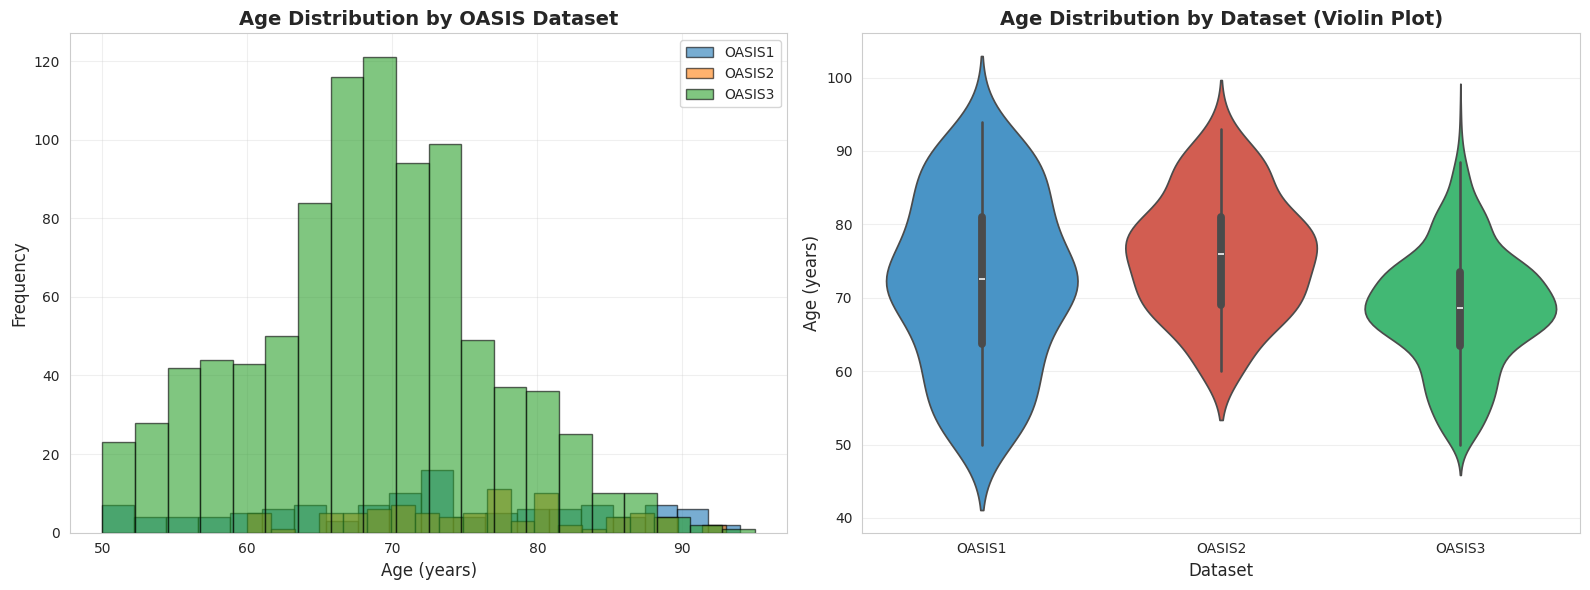

In [6]:
# Age distribution by dataset
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram by dataset
for dataset in ['OASIS1', 'OASIS2', 'OASIS3']:
    data = oasis_combined[oasis_combined['dataset'] == dataset]['age']
    axes[0].hist(data, bins=20, alpha=0.6, label=dataset, edgecolor='black')

axes[0].set_xlabel('Age (years)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Age Distribution by OASIS Dataset', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Violin plot
dataset_colors = {'OASIS1': '#3498db', 'OASIS2': '#e74c3c', 'OASIS3': '#2ecc71'}
sns.violinplot(data=oasis_combined, x='dataset', y='age', ax=axes[1], palette=dataset_colors)
axes[1].set_xlabel('Dataset', fontsize=12)
axes[1].set_ylabel('Age (years)', fontsize=12)
axes[1].set_title('Age Distribution by Dataset (Violin Plot)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Visualizations: Sex Distribution

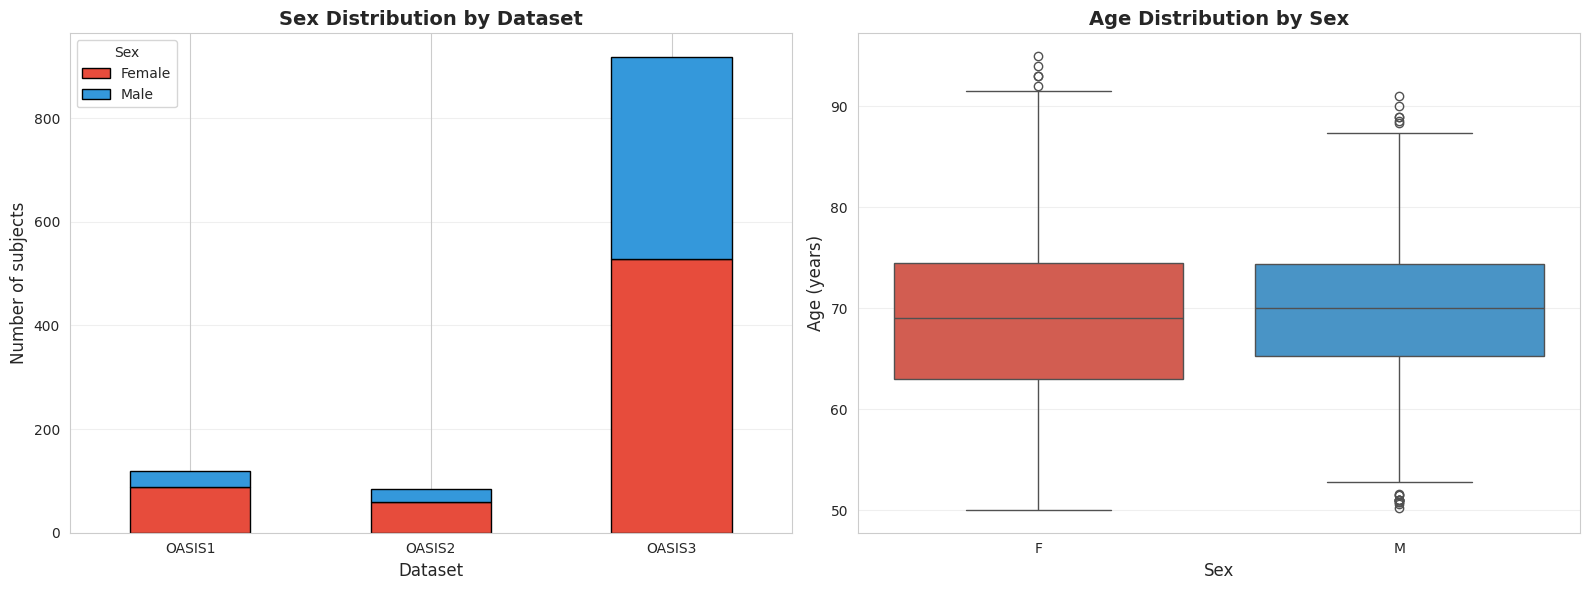

In [7]:
# Sex distribution by dataset
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
sex_by_dataset = oasis_combined.groupby(['dataset', 'sex']).size().unstack(fill_value=0)
sex_by_dataset.plot(kind='bar', stacked=True, ax=axes[0], color=['#e74c3c', '#3498db'], edgecolor='black')
axes[0].set_xlabel('Dataset', fontsize=12)
axes[0].set_ylabel('Number of subjects', fontsize=12)
axes[0].set_title('Sex Distribution by Dataset', fontsize=14, fontweight='bold')
axes[0].legend(title='Sex', labels=['Female', 'Male'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')

# Box plot: age by sex
sex_palette = {'M': '#3498db', 'F': '#e74c3c'}
sns.boxplot(data=oasis_combined, x='sex', y='age', palette=sex_palette, ax=axes[1])
axes[1].set_xlabel('Sex', fontsize=12)
axes[1].set_ylabel('Age (years)', fontsize=12)
axes[1].set_title('Age Distribution by Sex', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Visualizations: MMSE Scores

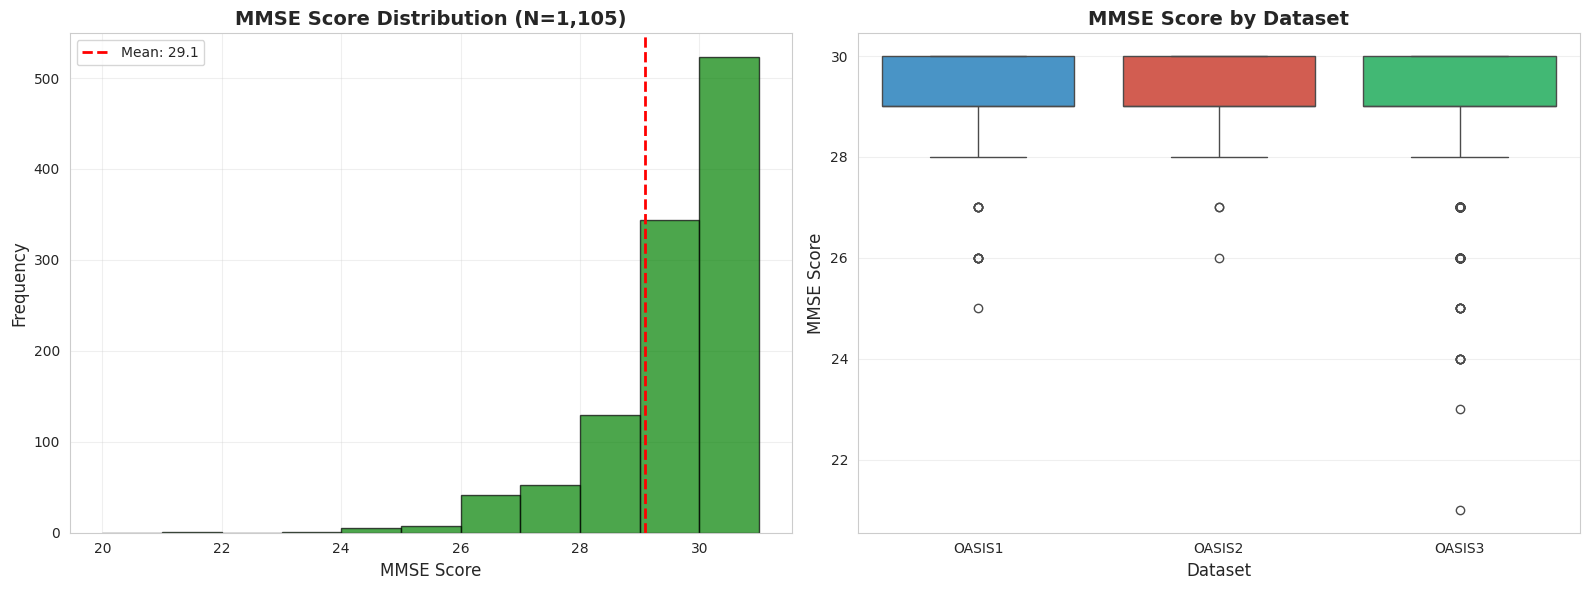

In [8]:
# MMSE score analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of MMSE scores
mmse_data = oasis_combined['mmse'].dropna()
axes[0].hist(mmse_data, bins=range(20, 32), edgecolor='black', alpha=0.7, color='green')
axes[0].axvline(mmse_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {mmse_data.mean():.1f}')
axes[0].set_xlabel('MMSE Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title(f'MMSE Score Distribution (N={len(mmse_data):,})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot: MMSE by dataset
oasis_with_mmse = oasis_combined[oasis_combined['mmse'].notna()]
sns.boxplot(data=oasis_with_mmse, x='dataset', y='mmse', ax=axes[1], palette=dataset_colors)
axes[1].set_xlabel('Dataset', fontsize=12)
axes[1].set_ylabel('MMSE Score', fontsize=12)
axes[1].set_title('MMSE Score by Dataset', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Age vs MMSE Scatter Plot

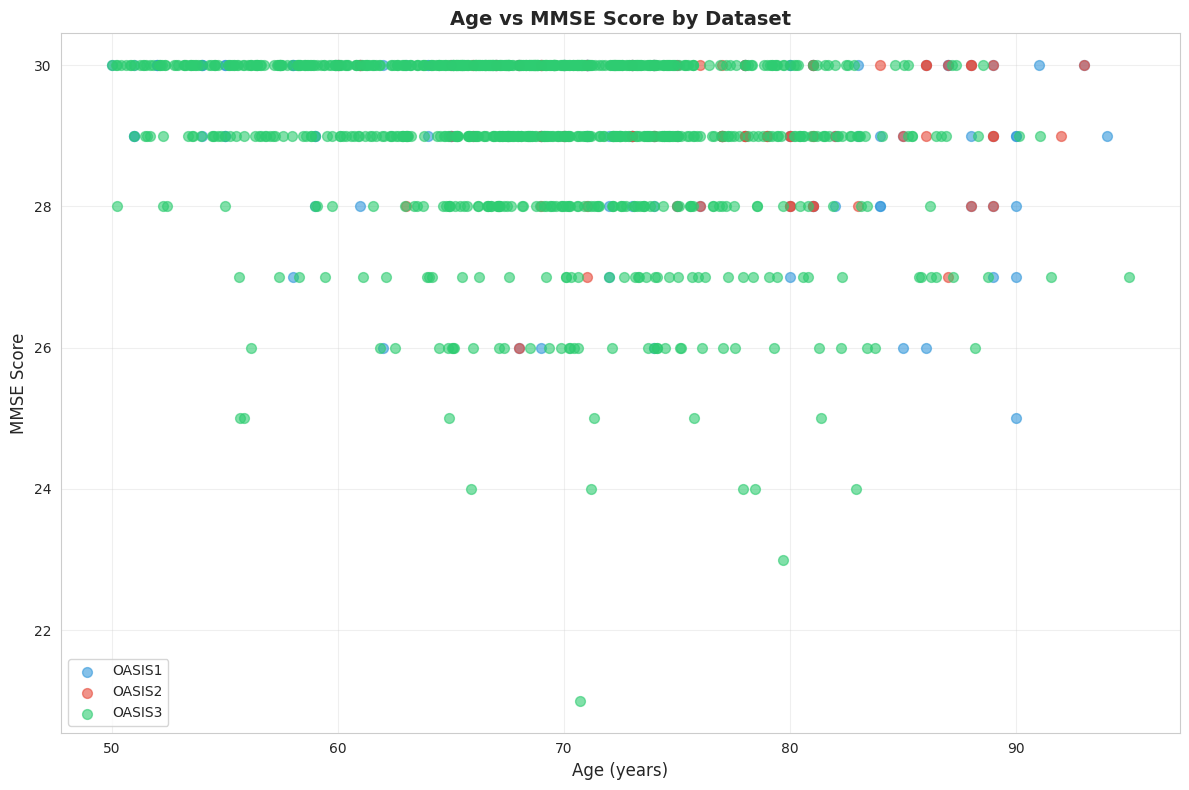

In [9]:
# Scatter plot: Age vs MMSE
fig, ax = plt.subplots(figsize=(12, 8))

for dataset in ['OASIS1', 'OASIS2', 'OASIS3']:
    data = oasis_combined[oasis_combined['dataset'] == dataset]
    data_clean = data[data['mmse'].notna()]
    ax.scatter(data_clean['age'], data_clean['mmse'], 
               label=dataset, alpha=0.6, s=50, 
               color=dataset_colors[dataset])

ax.set_xlabel('Age (years)', fontsize=12)
ax.set_ylabel('MMSE Score', fontsize=12)
ax.set_title('Age vs MMSE Score by Dataset', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Export Combined Dataset

In [10]:
# Save combined OASIS dataset
output_path = 'data/OASIS/oasis_combined_healthy_controls_age50plus.csv'
oasis_combined.to_csv(output_path, index=False)

print(f"✓ Exported combined OASIS dataset to: {output_path}")
print(f"\nDataset summary:")
print(f"  Total subjects: {len(oasis_combined):,}")
print(f"  OASIS-1: {(oasis_combined['dataset']=='OASIS1').sum():,}")
print(f"  OASIS-2: {(oasis_combined['dataset']=='OASIS2').sum():,}")
print(f"  OASIS-3: {(oasis_combined['dataset']=='OASIS3').sum():,}")
print(f"  Age range: {oasis_combined['age'].min():.0f}-{oasis_combined['age'].max():.0f} years")
print(f"  Sex: {(oasis_combined['sex']=='F').sum():,} F / {(oasis_combined['sex']=='M').sum():,} M")
print(f"\nFirst 10 rows:")
print(oasis_combined.head(10))

✓ Exported combined OASIS dataset to: data/OASIS/oasis_combined_healthy_controls_age50plus.csv

Dataset summary:
  Total subjects: 1,123
  OASIS-1: 120
  OASIS-2: 85
  OASIS-3: 918
  Age range: 50-95 years
  Sex: 676 F / 447 M

First 10 rows:
      subject_id   age sex  mmse  cdr dataset
0  OAS1_0001_MR1  74.0   F  29.0  0.0  OASIS1
1  OAS1_0002_MR1  55.0   F  29.0  0.0  OASIS1
2  OAS1_0010_MR1  74.0   M  30.0  0.0  OASIS1
3  OAS1_0011_MR1  52.0   F  30.0  0.0  OASIS1
4  OAS1_0013_MR1  81.0   F  30.0  0.0  OASIS1
5  OAS1_0019_MR1  89.0   F  30.0  0.0  OASIS1
6  OAS1_0026_MR1  58.0   F  30.0  0.0  OASIS1
7  OAS1_0030_MR1  65.0   F  29.0  0.0  OASIS1
8  OAS1_0032_MR1  89.0   M  28.0  0.0  OASIS1
9  OAS1_0033_MR1  80.0   F  29.0  0.0  OASIS1


## 10. Summary Statistics by Dataset

In [11]:
print("=" * 80)
print("COMPREHENSIVE OASIS SUMMARY (1 + 2 + 3)")
print("=" * 80)
print()

for dataset in ['OASIS1', 'OASIS2', 'OASIS3']:
    data = oasis_combined[oasis_combined['dataset'] == dataset]
    
    print(f"{dataset}:")
    print(f"  N: {len(data):,}")
    print(f"  Age: {data['age'].mean():.1f} ± {data['age'].std():.1f} (range: {data['age'].min():.0f}-{data['age'].max():.0f})")
    print(f"  Sex: {(data['sex']=='F').sum()} F ({(data['sex']=='F').sum()/len(data)*100:.1f}%) / {(data['sex']=='M').sum()} M ({(data['sex']=='M').sum()/len(data)*100:.1f}%)")
    
    mmse_data = data['mmse'].dropna()
    if len(mmse_data) > 0:
        print(f"  MMSE: {mmse_data.mean():.1f} ± {mmse_data.std():.1f} (N={len(mmse_data)})")
    else:
        print(f"  MMSE: N/A")
    print()

print("=" * 80)
print("TOTAL COMBINED:")
print(f"  N: {len(oasis_combined):,} healthy controls age ≥50")
print(f"  Age: {oasis_combined['age'].mean():.1f} ± {oasis_combined['age'].std():.1f}")
print(f"  Sex: {(oasis_combined['sex']=='F').sum():,} F / {(oasis_combined['sex']=='M').sum():,} M")
mmse_all = oasis_combined['mmse'].dropna()
print(f"  MMSE: {mmse_all.mean():.1f} ± {mmse_all.std():.1f} (N={len(mmse_all):,})")
print("=" * 80)

COMPREHENSIVE OASIS SUMMARY (1 + 2 + 3)

OASIS1:
  N: 120
  Age: 72.0 ± 11.6 (range: 50-94)
  Sex: 88 F (73.3%) / 32 M (26.7%)
  MMSE: 29.1 ± 1.2 (N=120)

OASIS2:
  N: 85
  Age: 75.8 ± 8.1 (range: 60-93)
  Sex: 59 F (69.4%) / 26 M (30.6%)
  MMSE: 29.2 ± 0.9 (N=85)

OASIS3:
  N: 918
  Age: 68.3 ± 8.1 (range: 50-95)
  Sex: 529 F (57.6%) / 389 M (42.4%)
  MMSE: 29.1 ± 1.2 (N=900)

TOTAL COMBINED:
  N: 1,123 healthy controls age ≥50
  Age: 69.3 ± 8.8
  Sex: 676 F / 447 M
  MMSE: 29.1 ± 1.2 (N=1,105)
